In [12]:
import matplotlib.font_manager
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random 
import csv
from IPython.display import display, Math
from numpy import unravel_index
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from astropy.table import Table, vstack

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

plt.rcParams["font.family"] = "TeX Gyre Schola Math"

print("Raw Transverse Velocities")

Raw Transverse Velocities


In [13]:
#Define the colour map that we will use all along
cmap = LinearSegmentedColormap.from_list('truncated_bone', ['#000000', '#171720', '#676f87', '#8ba1ab', '#e8f0f0'], N=256)
cmap.set_bad(color='gray')

## Import the data

### Importing the data from Gaia

In [5]:
def OutCVSGaia(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3, LIST4, LIST5, LIST6, LIST7 = [], [], [], [], [], [], []
    with open('ThisIsTheData/' + name + '.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            LIST1.append(float(row[0])) #x position
            LIST2.append(float(row[1])) #y position
            LIST3.append(float(row[2])) #pmra
            LIST4.append(float(row[3])) #sigma on the pmra
            LIST5.append(float(row[4])) #pmdec
            LIST6.append(float(row[5])) #sigma on the pmdec
            LIST7.append(float(row[6])) #pmra and pmdec correlations
            
    return LIST1, LIST2, LIST3, LIST4, LIST5, LIST6, LIST7

In [6]:
#We first import all the position of the different stars
x_All, y_All, pmra_All, pmra_sig_All, pmdec_All, pmdec_sig_All, pm_corr_All        = OutCVSGaia('AllStars')
x_Blue, y_Blue, pmra_Blue, pmra_sig_Blue, pmdec_Blue, pmdec_sig_Blue, pm_corr_Blue = OutCVSGaia('BlueStars')
x_Red, y_Red, pmra_Red, pmra_sig_Red, pmdec_Red, pmdec_sig_Red, pm_corr_Red        = OutCVSGaia('RedStars')

### Organising the data from the Gaia data

In [7]:
def OrganiseGaiaData(x, y, pmra, pmra_e, pmdec, pmdec_e, pm_corr):
    #___ Description_____________________________________________________________________________________
    #Arguments:: gives all the relevant quantities
    #Returns:: list with all the different significant quantities localised in it
    #____________________________________________________________________________________________________
     
    GaiaData = []
    
    GaiaData.append(x)
    GaiaData.append(y)
    GaiaData.append(pmra)
    GaiaData.append(pmra_e)
    GaiaData.append(pmdec)
    GaiaData.append(pmdec_e)
    GaiaData.append(pm_corr)
    
    return GaiaData

In [8]:
GaiaDataAll  = OrganiseGaiaData(x_All, y_All, pmra_All, pmra_sig_All, pmdec_All, pmdec_sig_All, pm_corr_All)
GaiaDataBlue = OrganiseGaiaData(x_Blue, y_Blue, pmra_Blue, pmra_sig_Blue, pmdec_Blue, pmdec_sig_Blue, pm_corr_Blue)
GaiaDataRed  = OrganiseGaiaData(x_Red, y_Red, pmra_Red, pmra_sig_Red, pmdec_Red, pmdec_sig_Red, pm_corr_Red)

### Importing the data from the model

In [9]:
def OutCVSModel(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3 = [], [], []
    if name != "model":
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append([float(row[0]), float(row[1])])
        return LIST1
    
    else:
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append(float(row[0]))
                LIST2.append(float(row[1]))
                LIST3.append(-float(row[2]))
        return LIST1, LIST2, LIST3        

In [10]:
#Reading the cvs files
xb = OutCVSModel('x_edges') #all x the edges of the bins
yb = OutCVSModel('y_edges') #all the y edges of the bins
vb = OutCVSModel('vel')     #all the heliocentric velocities of the bins

x_model, y_model, z_model = OutCVSModel("model")

## Superimposing the model with the data 

We will first do a sort of visual check to see if the model we have and the data coming from gaia actually do match, and as we can see below, they seem to match pretty well. Noice.

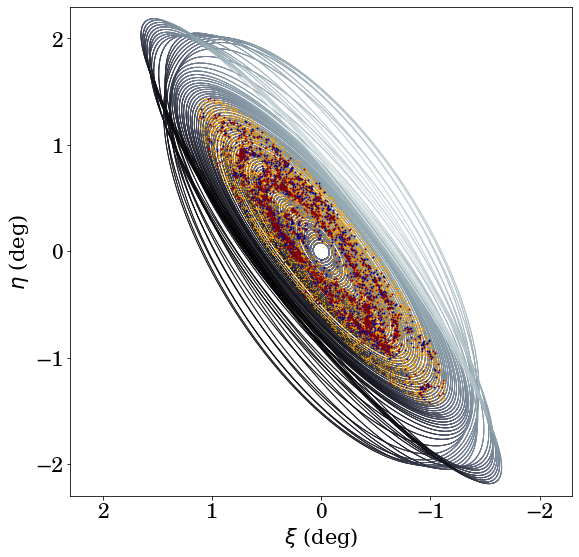

In [11]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)

#Plot of the stars coming from gaia
plt.scatter(x_All, y_All, s=0.1, color='orange')
plt.scatter(x_Blue, y_Blue, s=0.9, color='darkblue')
plt.scatter(x_Red, y_Red, s=0.9, color='darkred')

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

## Velocity of the stars from Gaia

In this section we will create a function that will allow us to know in which bin a star is located and hence go back to the velocity with which it should be observed based on the rotation model (in the heliocentric frame).

In [12]:
def FindBin(x, y, x_intervals, y_intervals, vel):
    #___ Description_____________________________________________________________________________________
    #Arguments:: coordinates of the point, lists of the intervals (along x and y) and the list of the 
    #           components of the velocity along each axis
    #Returns:: returns the components of the velocity in the bin in mas/yr
    #____________________________________________________________________________________________________
     
    #We first determine in which bin the point/star is located
    count = 0
    for i in range(len(x_intervals)):
        if x > x_intervals[i][0] and x < x_intervals[i][1]:
            if y > y_intervals[i][0] and y < y_intervals[i][1]:
                count = i    
                
    #Let's convert the velocity from km/s to mas/yr
    RadDist = 780*3.08E16 #Radial distance from M31 in km
    YrToSec = 365.25*86400 #Years to seconds
    
    pm_ra  = ((vel[count][0]*YrToSec)/(RadDist*4.84814E-9))
    pm_dec = (vel[count][1]*YrToSec)/(RadDist*4.84814E-9)

    return pm_ra, pm_dec

### Organising the data from the model

In [13]:
def OrganiseModelData(x_stars, y_stars, x_bounds, y_bounds, vel):
    #___ Description_____________________________________________________________________________________
    #Arguments:: 'x' and 'y_stars' are lists of the coordinates of the star for which we want the proper
    #           motion. 'x' and 'y_bounds' are the limits of the bins of the model and 'vel' the 
    #           velocities associated in each of those
    #Returns:: returns a list with all the proper motions of the stars in mas/yr
    #____________________________________________________________________________________________________

    ModelData = [[], []]
        
    for i in range(len(x_stars)):
        Temporary = FindBin(x_stars[i], y_stars[i], xb, yb, vb)
        ModelData[0].append(Temporary[0])
        ModelData[1].append(Temporary[1])
    
    return ModelData

In [14]:
#ModelDataAll  = OrganiseModelData(GaiaDataAll[0], GaiaDataAll[1], xb, yb, vb)
ModelDataBlue = OrganiseModelData(GaiaDataBlue[0], GaiaDataBlue[1], xb, yb, vb)
ModelDataRed  = OrganiseModelData(GaiaDataRed[0], GaiaDataRed[1], xb, yb, vb)

#### Let's quickly visualise if this worked by superimposing the velocities from the model that we gave to the stars of the Gaia data

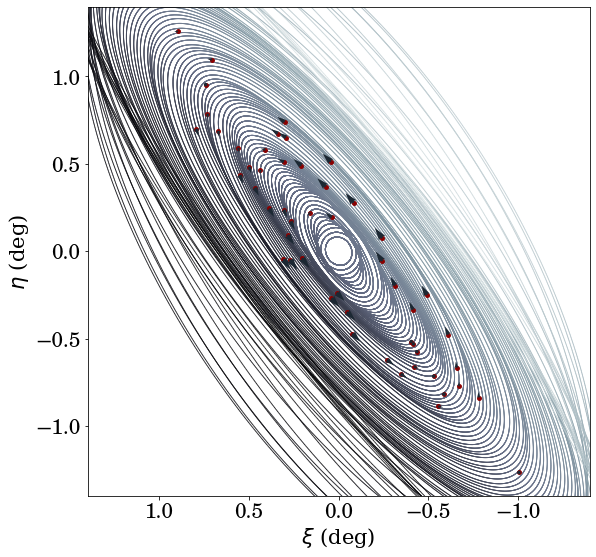

In [15]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)

for i in range(len(x_Red)):
    if i % 2 == 0 and i % 3 == 0 and i %5 == 0:
        plt.scatter(x_Red[i], y_Red[i], s=15, color='darkred')
        plt.quiver(x_Red[i], y_Red[i], ModelDataRed[0][i], ModelDataRed[1][i], angles='xy', scale_units='xy', scale=1, color='#1c2833') 
                
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-1.4, 1.4)
plt.ylim(-1.4, 1.4)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('42.png', dpi=150)
plt.show()

#### Now let's visualise the data coming directly from gaia, here for the red sample

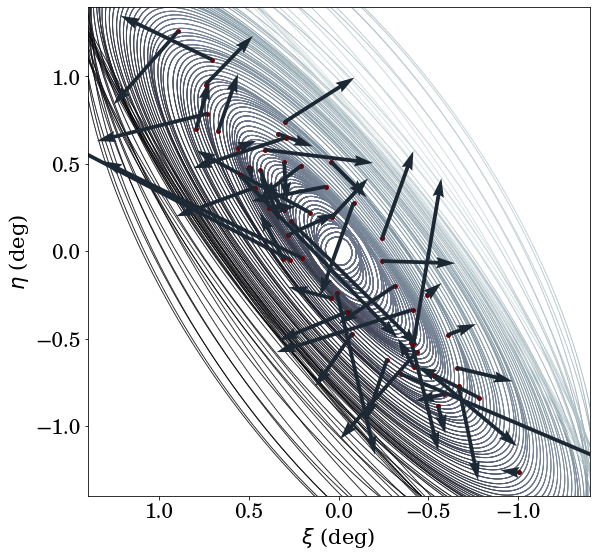

In [20]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)

for i in range(len(x_Red)):
    if i % 2 == 0 and i % 3 == 0 and i %5 == 0:
        plt.scatter(x_Red[i], y_Red[i], s=15, color='#720000')
        plt.quiver(x_Red[i], y_Red[i], GaiaDataRed[2][i], GaiaDataRed[4][i], angles='xy', scale_units='xy', scale=1, color='#1c2833') 
                
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-1.4, 1.4)
plt.ylim(-1.4, 1.4)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
plt.savefig('GaiaMess.png', dpi=150)
plt.show()

## Mock data

In [18]:
def MockData(GaiaData, ModelData):
    vel_ra, vel_dec = [], []
    
    #Modelling the bulk motion
    random_ra_bulk  = [0]  #It's 0, so not so random
    random_dec_bulk = [0]
        
    #Modelling the error on the proper motion
    for i in range(len(GaiaData[0])):
        random_ra_error  = np.random.normal(0, GaiaData[3], 1)
        random_dec_error = np.random.normal(0, GaiaData[5], 1)

        vel_ra.append(ModelData[0][i] + random_ra_bulk[0] + random_ra_error[0]) 
        vel_dec.append(ModelData[1][i] + random_dec_bulk[0] + random_dec_error[0])
        
    return [vel_ra, vel_dec]

## Determination of the likelihood

In [21]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData, CalcMeth):
        self.NbModels = NbModels
        self.CalcMeth = CalcMeth #Calculation method
    
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        self.corr             = GaiaData[6]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        method_to_call = getattr(self, self.CalcMeth)
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += method_to_call(k, i, j)

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return self.ra_max*1000, self.index_border_y*self.space*1000, self.dec_max*1000, self.index_border_x*self.space*1000, self.space*1000
                
    def FreeParameters(self):
        self.pm_ra_M31  = np.linspace(-0.1, 0.1, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.1, 0.1, self.NbModels)
                
        self.space = (self.pm_ra_M31[-1] - self.pm_ra_M31[-2])
    
    def CythonLike(self, index_star, index_model_ra, index_model_dec):
        return LikelihoodCFunction(self.pm_ra_M31[index_model_ra], self.pm_dec_M31[index_model_dec], 
                                    self.mu_ra_model[index_star], self.mu_dec_model[index_star],
                                    self.mu_ra_sig_gaia[index_star], self.mu_dec_sig_gaia[index_star], 
                                    self.mu_ra_gaia[index_star], self.mu_dec_gaia[index_star])
      
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_M31[dec_max], self.pm_dec_M31[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
        sum_x = sum(self.x_gaus)
        x_gaus = [x / sum_x for x in self.x_gaus]

        sum_y = sum(self.y_gaus)
        y_gaus = [y / sum_y for y in self.y_gaus]

        self.index_centre_x = x_gaus.index(max(x_gaus))
        self.index_centre_y = y_gaus.index(max(y_gaus))

        sum_x, sum_y = x_gaus[self.index_centre_x], y_gaus[self.index_centre_y]
        
        self.index_border_x = 0
        while sum_x < 0.683:
            self.index_border_x += 1
            sum_x += x_gaus[self.index_centre_x + self.index_border_x]
            sum_x += x_gaus[self.index_centre_x - self.index_border_x]
            
        self.index_border_y = 0
        while sum_y < 0.683:
            self.index_border_y += 1
            sum_y += y_gaus[self.index_centre_y + self.index_border_y]
            sum_y += y_gaus[self.index_centre_y - self.index_border_y]
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x * 1000 for x in self.pm_ra_M31], [x * 1000 for x in self.pm_dec_M31], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#8FACB9', '#56676F', '#000000'])
            ax.scatter(self.ra_max*1000, self.dec_max*1000, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_M31)):
                self.x_bins.append(self.pm_ra_M31[i] - self.space/2)
            for i in range(len(self.pm_ra_M31)):
                self.y_bins.append(self.pm_dec_M31[i] - self.space/2)

            #Plot of the RA histogram
            ax_histx.bar([x * 1000 for x in self.x_bins], self.y_gaus, width=self.space*1000, align='edge', 
                         edgecolor='black', color='#646b84', alpha=0.8, zorder=3)
            ax_histx.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            ax_histx.set_yticklabels([])
            #self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            ax_histy.barh([x * 1000 for x in self.y_bins], self.x_gaus, height=self.space*1000, align='edge', 
                          edgecolor='black', color='#646b84', alpha=0.8, zorder=3)
            ax_histy.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            ax_histy.set_xticklabels([])
            #self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(10, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #plt.savefig('Likelihood.png', dpi=300)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + "\pm" + str(
            round(abs(self.index_border_y*self.space*1000), 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + "\pm" + str(
            round(abs(self.index_border_x*self.space*1000), 1))  + r"\ \mu as/yr"))

### Let's make a loop in order to determine the typical errors on the recovering of the proper motion

This step is made in order to see if we have systematics in our results. For the first series of tests give a velocity of 0 in both directions to M31 and we want to recover this velocity. We explore a total domain of $\pm$50$\mu$as.yr$^{-1}$ (so to be clearer a 100$\mu$as.yr$^{-1}$) in both $\alpha$ and $\delta$ directions and we will explore this domain using three different "densities of exploration". Now, the reader might ask himself what is meant by that. It is simply a way to quantify how many values are tested along each axis. The densities will be the following:

- 21 points per 100$\mu$as.yr$^{-1}$
- 42 points per 100$\mu$as.yr$^{-1}$
- 99 points per 100$\mu$as.yr$^{-1}$

In [22]:
class Statistics():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbTests, NbDensity):
        self.centre_ra, self.centre_dec = [], []
        
        self.NbTests   = NbTests
        self.NbDensity = NbDensity
        
    #____Methods::_______________________________________________________________________________________    
    def DoStatistics(self):
        for i in range(self.NbTests):
            Test    = MockData(GaiaDataBlue, ModelDataBlue)
            ObjLike = LikelihooD(self.NbDensity, GaiaDataBlue, ModelDataBlue, Test, "CythonLike")
            Answer  = ObjLike.Execute()

            self.centre_ra.append(Answer[0])
            self.centre_dec.append(Answer[2]) 
            
        self.RecoveredVelocities()    
        #self.PlotHisto()
        self.PrintStatistics()
        #self.Hist()
            
    def RecoveredVelocities(self):
        with open('ThisIsTheData/TestStatistics/' + str(self.NbTests) + "_non_zero_models_" + str(self.NbDensity) + 
                  '.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            for i in range(len(self.centre_ra)):
                writer.writerow([self.centre_ra[i], self.centre_dec[i]])   
                
    def PlotHisto(self): 
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6.5))
        
        nb_bins = 15
        
        n, bins, patches = ax1.hist(self.centre_ra, bins=nb_bins,
                                    edgecolor='black', color='#7799A5', alpha=0.9)
      
        ax1.set_xlabel(r'Deviation from 0 along $\alpha$ ($\mu$as.yr$^{-1}$)', fontname = 'Serif', size = 18)
        ax1.set_ylabel('Occurrences', fontname = 'Serif', size = 18)
        ax1.xaxis.set_tick_params(labelsize=18)
        ax1.yaxis.set_tick_params(labelsize=18)
        
        n, bins, patches = ax2.hist(self.centre_dec, bins=nb_bins, 
                                    edgecolor='black', color='#7799A5', alpha=0.9)
        
        ax2.set_xlabel(r'Deviation from 0 along $\delta$ ($\mu$as.yr$^{-1}$)', fontname = 'Serif', size = 18)
        ax2.set_ylabel('Occurrences', fontname = 'Serif', size = 18)
        ax2.xaxis.set_tick_params(labelsize=18)
        ax2.yaxis.set_tick_params(labelsize=18)
        
        plt.savefig("Histo" + str(self.NbDensity) + ".png", dpi=300)
        plt.show()
        
    def PrintStatistics(self):
        self.ra_mean     = np.mean(self.centre_ra)
        self.dec_mean    = np.mean(self.centre_dec)
        self.ra_std_dev  = np.std(self.centre_ra, ddof=0)
        self.dec_std_dev = np.std(self.centre_dec, ddof=0)

        display(Math(r"(\mu_{\alpha, M31}, \mu_{\delta, M31} ) = (" + str(round(self.ra_mean, 2)) + "\pm" +
                     str(round(self.ra_std_dev, 2)) + "," + str(round(self.dec_mean, 2)) + "\pm" +
                     str(round(self.dec_std_dev, 2)) + r")\ \mu as.yr^{-1}"))  
    
    def Hist(self):
        def normal_distribution(x, mu, sigma):
            return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

        plt.figure(figsize=(8, 6))
        min_vals = min(self.centre_ra + self.centre_dec)
        max_vals = max(self.centre_ra + self.centre_dec)
        x = np.linspace(min_vals, max_vals, 1000)
        
        bins_ = np.arange(min_vals, max_vals, 3)
        
        hist_ra, _, _ = plt.hist(self.centre_ra, bins=bins_, density=True, edgecolor='black', 
                                 color='#171720', alpha=0.8, label=r'$\mu_{\alpha}$')
        hist_dec, _, _ = plt.hist(self.centre_dec, bins=bins_,  density=True, edgecolor='black', 
                 color='#e8f0f0', alpha=0.6, label=r'$\mu_{\delta}$')
        
        pdf_a = normal_distribution(x, self.ra_mean, self.ra_std_dev)
        pdf_d = normal_distribution(x, self.dec_mean, self.dec_std_dev)
        
        plt.plot(x, pdf_a, color='#171720', linewidth=2)
        plt.vlines(x=self.ra_mean, ymin=0, ymax=max(pdf_a), color='#171720')
        plt.plot(x, pdf_d, color='#e8f0f0', linewidth=2)
        plt.vlines(x=self.dec_mean, ymin=0, ymax=max(pdf_d), color='#e8f0f0')
        plt.xlabel(r'Deviation from 0 along $\alpha$ and $\delta$ ($\mu$as.yr$^{-1}$)', fontname = 'Serif', size = 18)
        #plt.ylabel('Occurrences', fontname = 'Serif', size = 18)
        plt.legend(fontsize = 15)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 0)

        #plt.savefig("Histo" + str(self.NbDensity) + "1.png", dpi=300)
        plt.show()

In [1]:
choice = input("Are you sure you want to lauch the program, this might take a while? (Yes/No): ")

if choice == "Yes":
    ObjStat = Statistics(1000, 21)
    ObjStat.DoStatistics()
    
    ObjStat = Statistics(1000, 42)
    ObjStat.DoStatistics()
    
    ObjStat = Statistics(1000, 99)
    ObjStat.DoStatistics()

Are you sure you want to lauch the program, this might take a while? (Yes/No): No


In [23]:
def OutCVS(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: importants the data from the 1000 tests
    #____________________________________________________________________________________________________
  
    LIST1, LIST2 = [], []
    with open('ThisIsTheData/TestStatistics/' + name + '.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            LIST1.append(float(row[0])) #x position
            LIST2.append(float(row[1])) #y position
            
    return LIST1, LIST2

In [36]:
Ra, Dec = OutCVS("1000_models_99")

In [37]:
ra_mean     = np.mean(Ra)
dec_mean    = np.mean(Dec)
ra_std_dev  = np.std(Ra, ddof=0)
dec_std_dev = np.std(Dec, ddof=0)

'texgyreschola-math.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


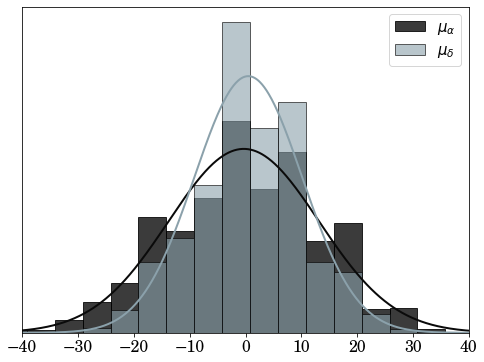

<IPython.core.display.Math object>

In [39]:
def normal_distribution(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

plt.figure(figsize=(8, 6))
min_vals = min(Ra + Dec)
max_vals = max(Ra + Dec)
x = np.linspace(min_vals, max_vals, 1000)
        
bins_ = np.arange(min_vals, max_vals, 5)
        
hist_ra, _, _  = plt.hist(Ra, bins=bins_, density=True, edgecolor='black',
                          color='#0a0a0a', alpha=0.8, label=r'$\mu_{\alpha}$')
hist_dec, _, _ = plt.hist(Dec, bins=bins_,  density=True, edgecolor='black', 
                          color='#8ba1ab', alpha=0.6, label=r'$\mu_{\delta}$')
        
pdf_a = normal_distribution(x, ra_mean, ra_std_dev)
pdf_d = normal_distribution(x, dec_mean, dec_std_dev)
        
plt.plot(x, pdf_a, color='#0a0a0a', linewidth=2)
#plt.vlines(x=ra_mean, ymin=0, ymax=max(pdf_a), color='#0a0a0a')
plt.plot(x, pdf_d, color='#8ba1ab', linewidth=2)
#plt.vlines(x=dec_mean, ymin=0, ymax=max(pdf_d), color='#8ba1ab')
#plt.xlabel(r'Deviation from 0 along $\alpha$ and $\delta$ ($\mu$as.yr$^{-1}$)', fontname = 'Serif', size = 18)
        #plt.ylabel('Occurrences', fontname = 'Serif', size = 18)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 16)
plt.yticks([])
plt.xlim(-40, 40)

#plt.savefig("Histo" + str(1000) + "1.png", dpi=300)
plt.savefig("Histo" + str(1000) + "1.pdf")
plt.show()

display(Math(r"(\mu_{\alpha, M31}, \mu_{\delta, M31} ) = (" + str(round(ra_mean, 2)) + "\pm" +
            str(round(ra_std_dev, 2)) + "," + str(round(dec_mean, 2)) + "\pm" +
            str(round(dec_std_dev, 2)) + r")\ \mu as.yr^{-1}"))  

## Mock data but not centred on 0

This second test aims to see if the method can recover a non zero velocity that we give to stars.

In [27]:
def MockData(GaiaData, ModelData):
    vel_ra, vel_dec = [], []
    
    #Modelling the bulk motion
    random_ra_bulk  = [0.043]
    random_dec_bulk = [-0.030]
        
    #Modelling the error on the proper motion
    for i in range(len(GaiaData[0])):
        random_ra_error  = np.random.normal(0, GaiaData[3], 1)
        random_dec_error = np.random.normal(0, GaiaData[5], 1)

        vel_ra.append(ModelData[0][i] + random_ra_bulk[0] + random_ra_error[0]) 
        vel_dec.append(ModelData[1][i] + random_dec_bulk[0] + random_dec_error[0])
        
    return [vel_ra, vel_dec]

In [28]:
choice = input("Are you sure you want to lauch the program, this might take a while? (Yes/No): ")

if choice == "Yes":
    ObjStat = Statistics(1000, 99)
    ObjStat.DoStatistics()

Are you sure you want to lauch the program, this might take a while? (Yes/No): Yes


<IPython.core.display.Math object>

In [31]:
Ra, Dec = OutCVS("1000_non_zero_models_99")

In [32]:
ra_mean     = np.mean(Ra)
dec_mean    = np.mean(Dec)
ra_std_dev  = np.std(Ra, ddof=0)
dec_std_dev = np.std(Dec, ddof=0)

'texgyreschola-math.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


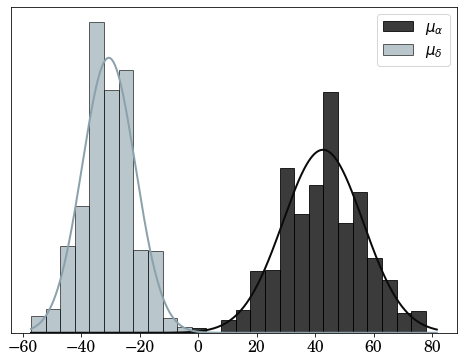

<IPython.core.display.Math object>

In [35]:
def normal_distribution(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

plt.figure(figsize=(8, 6))
min_vals = min(Ra + Dec)
max_vals = max(Ra + Dec)
x = np.linspace(min_vals, max_vals, 1000)
        
bins_ = np.arange(min_vals, max_vals, 5)
        
hist_ra, _, _  = plt.hist(Ra, bins=bins_, density=True, edgecolor='black',
                          color='#0a0a0a', alpha=0.8, label=r'$\mu_{\alpha}$')
hist_dec, _, _ = plt.hist(Dec, bins=bins_,  density=True, edgecolor='black', 
                          color='#8ba1ab', alpha=0.6, label=r'$\mu_{\delta}$')
        
pdf_a = normal_distribution(x, ra_mean, ra_std_dev)
pdf_d = normal_distribution(x, dec_mean, dec_std_dev)
        
plt.plot(x, pdf_a, color='#0a0a0a', linewidth=2)
#plt.vlines(x=ra_mean, ymin=0, ymax=max(pdf_a), color='#0a0a0a')
plt.plot(x, pdf_d, color='#8ba1ab', linewidth=2)
#plt.vlines(x=dec_mean, ymin=0, ymax=max(pdf_d), color='#8ba1ab')
#plt.xlabel(r'Deviation from 0 along $\alpha$ and $\delta$ ($\mu$as.yr$^{-1}$)', fontname = 'Serif', size = 18)
        #plt.ylabel('Occurrences', fontname = 'Serif', size = 18)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 16)
plt.yticks([])

#plt.savefig("Histo" + str(1000) + "1.png", dpi=300)
plt.savefig("Histo" + str(1000) + "2.pdf")
plt.show()

display(Math(r"(\mu_{\alpha, M31}, \mu_{\delta, M31} ) = (" + str(round(ra_mean, 2)) + "\pm" +
            str(round(ra_std_dev, 2)) + "," + str(round(dec_mean, 2)) + "\pm" +
            str(round(dec_std_dev, 2)) + r")\ \mu as.yr^{-1}"))  

## Apply the method to the data

After having done the tests and seeing that our likelihood class is actually able to recover the bulk motion pretty accurately, we can now apply it on our data, and hence go back to the result we actually want to recover.

In [17]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData, CalcMeth):
        self.NbModels = NbModels
        self.CalcMeth = CalcMeth #Calculation method
    
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        self.corr             = GaiaData[6]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        method_to_call = getattr(self, self.CalcMeth)
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += method_to_call(k, i, j)

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return self.ra_max*1000, self.index_border_y*self.space*1000, self.dec_max*1000, self.index_border_x*self.space*1000, self.space*1000
                
    def FreeParameters(self):
        #self.pm_ra_M31  = np.linspace(0., 0.1, self.NbModels) #For blue/red stars not in quadrants
        #self.pm_dec_M31 = np.linspace(-0.1, 0., self.NbModels)
        
        self.pm_ra_M31  = np.linspace(-0.01, 0.130, self.NbModels) #For blue stars in quadrants
        self.pm_dec_M31 = np.linspace(-0.1, 0.04, self.NbModels)
        
        #self.pm_ra_M31  = np.linspace(-0.06, 0.120, self.NbModels) #For red stars in quadrants
        #self.pm_dec_M31 = np.linspace(-0.15, 0.03, self.NbModels)
            
        #self.pm_ra_M31  = np.linspace(-0.05, 0.05, self.NbModels) #For 0 tests
        #self.pm_dec_M31 = np.linspace(-0.05, 0.05, self.NbModels)
        
        self.space = (self.pm_ra_M31[-1] - self.pm_ra_M31[-2])
        
    def PythonLike(self, index_star, index_model_ra, index_model_dec):
        GaussianCenter_ra  = self.pm_ra_M31[index_model_ra] + self.mu_ra_model[index_star]
        GaussianCenter_dec = self.pm_dec_M31[index_model_dec] + self.mu_dec_model[index_star]

        PreFactor = 1/(2*np.pi*self.mu_ra_sig_gaia[index_star]*self.mu_dec_sig_gaia[index_star])    
        ExpRa  = -0.5*((self.mu_ra_gaia[index_star] - GaussianCenter_ra)/(self.mu_ra_sig_gaia[index_star]))**2
        ExpDec = -0.5*((self.mu_dec_gaia[index_star] - GaussianCenter_dec)/(self.mu_dec_sig_gaia[index_star]))**2
        
        return np.log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)
    
    def PythonLikeCorr(self, index_star, index_model_ra, index_model_dec):
        GaussianCenter_ra  = self.pm_ra_M31[index_model_ra] + self.mu_ra_model[index_star]
        GaussianCenter_dec = self.pm_dec_M31[index_model_dec] + self.mu_dec_model[index_star]

        PreFactor = 1/(2*np.pi*self.mu_ra_sig_gaia[index_star]*self.mu_dec_sig_gaia[index_star]*np.sqrt(1 - self.corr[index_star]**2))    
        ExpRa  = -(1/(2*(1 - self.corr[index_star]**2)))*((self.mu_ra_gaia[index_star] - GaussianCenter_ra
                                                          )/(self.mu_ra_sig_gaia[index_star]))**2
        ExpDec = -(1/(2*(1 - self.corr[index_star]**2)))*((self.mu_dec_gaia[index_star] - GaussianCenter_dec
                                                          )/(self.mu_dec_sig_gaia[index_star]))**2
        ExpCor = (1/(2*(1 - self.corr[index_star]**2)))*((2*self.corr[index_star]*(
                                                           self.mu_ra_gaia[index_star] - GaussianCenter_ra)*(
                                                           self.mu_dec_gaia[index_star] - GaussianCenter_dec))/(
                                                           self.mu_ra_sig_gaia[index_star]*self.mu_dec_sig_gaia[index_star]))
        
        return np.log(PreFactor) + ExpRa + ExpDec + ExpCor #exp to come back to the L and not ln(L)
    
    def CythonLike(self, index_star, index_model_ra, index_model_dec):
        return LikelihoodCFunction(self.pm_ra_M31[index_model_ra], self.pm_dec_M31[index_model_dec], 
                                    self.mu_ra_model[index_star], self.mu_dec_model[index_star],
                                    self.mu_ra_sig_gaia[index_star], self.mu_dec_sig_gaia[index_star], 
                                    self.mu_ra_gaia[index_star], self.mu_dec_gaia[index_star])
    
    def CythonLikeCorr(self, index_star, index_model_ra, index_model_dec):
        return LikelihoodCFunctionCorr(self.pm_ra_M31[index_model_ra], self.pm_dec_M31[index_model_dec], 
                                    self.mu_ra_model[index_star], self.mu_dec_model[index_star],
                                    self.mu_ra_sig_gaia[index_star], self.mu_dec_sig_gaia[index_star], 
                                    self.mu_ra_gaia[index_star], self.mu_dec_gaia[index_star], self.corr[index_star])
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_M31[dec_max], self.pm_dec_M31[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
        sum_x = sum(self.x_gaus)
        x_gaus = [x / sum_x for x in self.x_gaus]

        sum_y = sum(self.y_gaus)
        y_gaus = [y / sum_y for y in self.y_gaus]

        self.index_centre_x = x_gaus.index(max(x_gaus))
        self.index_centre_y = y_gaus.index(max(y_gaus))

        sum_x, sum_y = x_gaus[self.index_centre_x], y_gaus[self.index_centre_y]
        
        self.index_border_x = 0
        while sum_x < 0.683:
            self.index_border_x += 1
            sum_x += x_gaus[self.index_centre_x + self.index_border_x]
            sum_x += x_gaus[self.index_centre_x - self.index_border_x]
            
        self.index_border_y = 0
        while sum_y < 0.683:
            self.index_border_y += 1
            sum_y += y_gaus[self.index_centre_y + self.index_border_y]
            sum_y += y_gaus[self.index_centre_y - self.index_border_y]
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x * 1000 for x in self.pm_ra_M31], [x * 1000 for x in self.pm_dec_M31], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#8FACB9', '#56676F', '#000000'])
            ax.scatter(self.ra_max*1000, self.dec_max*1000, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_M31)):
                self.x_bins.append(self.pm_ra_M31[i] - self.space/2)
            for i in range(len(self.pm_ra_M31)):
                self.y_bins.append(self.pm_dec_M31[i] - self.space/2)

            #Plot of the RA histogram
            ax_histx.bar([x * 1000 for x in self.x_bins], self.y_gaus, width=self.space*1000, align='edge', 
                         edgecolor='black', color='#646b84', alpha=0.8, zorder=3)
            ax_histx.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            ax_histx.set_yticklabels([])
            #self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            ax_histy.barh([x * 1000 for x in self.y_bins], self.x_gaus, height=self.space*1000, align='edge', 
                          edgecolor='black', color='#646b84', alpha=0.8, zorder=3)
            ax_histy.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            ax_histy.set_xticklabels([])
            #self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(10, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #plt.savefig('Likelihood.png', dpi=300)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + "\pm" + str(
            round(abs(self.index_border_y*self.space*1000), 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + "\pm" + str(
            round(abs(self.index_border_x*self.space*1000), 1))  + r"\ \mu as/yr"))

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 1min 17s, sys: 7.93 ms, total: 1min 17s
Wall time: 1min 17s


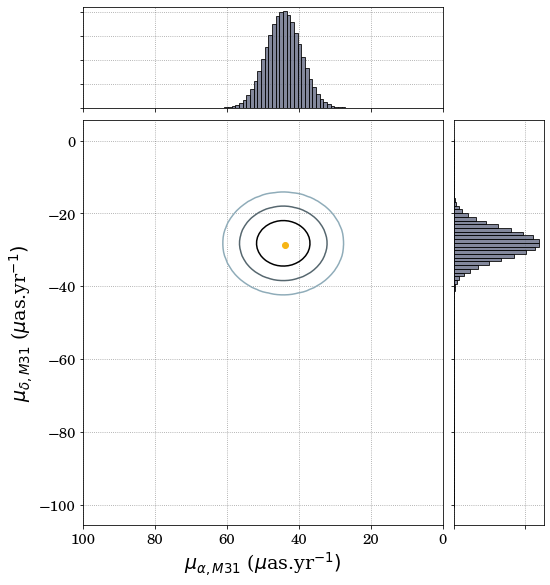

In [100]:
%%time
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [], "PythonLike")
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 1min 5s, sys: 0 ns, total: 1min 5s
Wall time: 1min 5s


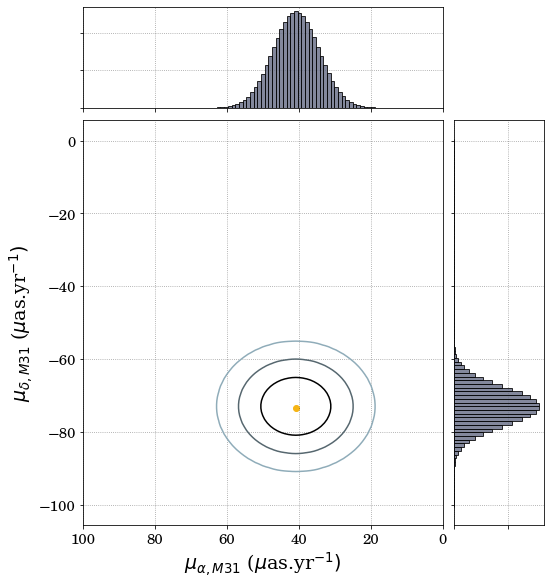

In [101]:
%%time
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [], "PythonLike")
ObjLike.Execute()
ObjLike.Plot()

# Taking into account the correlations

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 2min 27s, sys: 228 ms, total: 2min 27s
Wall time: 2min 27s


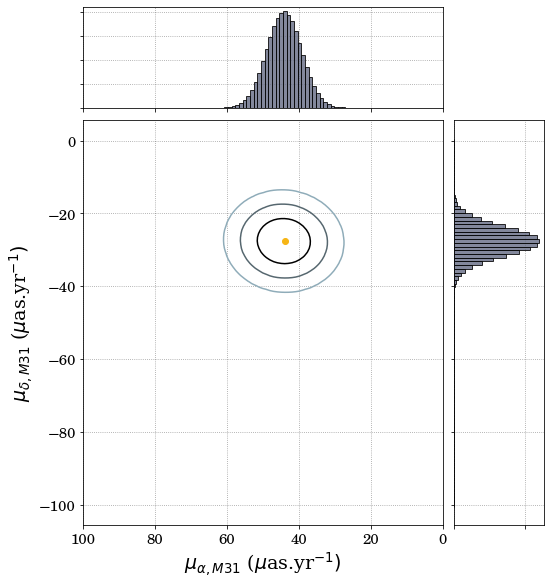

In [102]:
%%time
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [], "PythonLikeCorr")
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 2min 2s, sys: 91.9 ms, total: 2min 2s
Wall time: 2min 2s


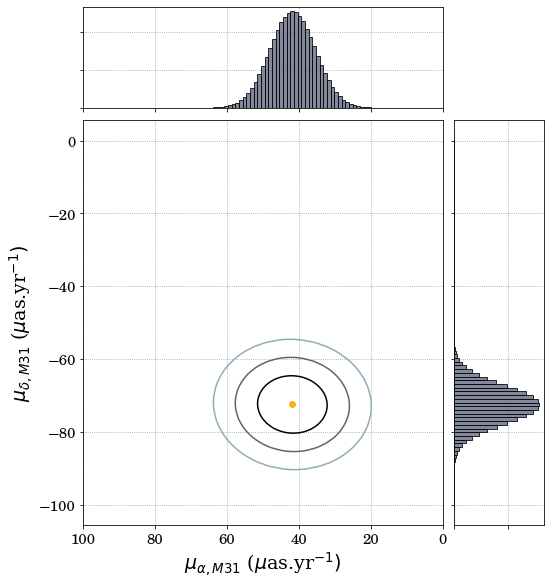

In [103]:
%%time
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [], "PythonLikeCorr")
ObjLike.Execute()
ObjLike.Plot()

# Use Cython to accelerate the program

## Without the correlations

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 25.3 s, sys: 16 ms, total: 25.4 s
Wall time: 25.5 s


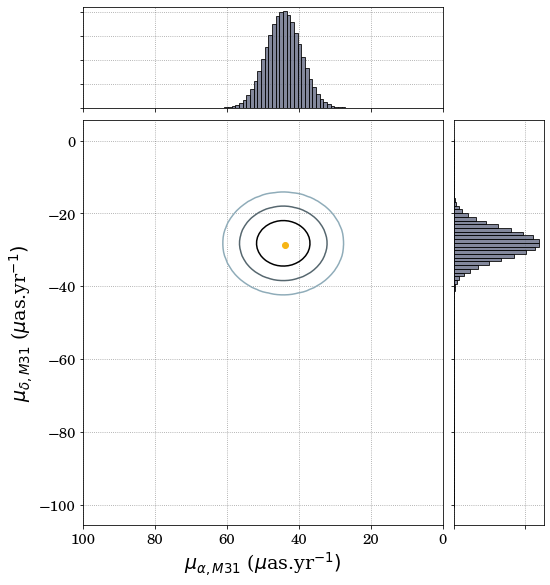

In [104]:
%%time
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [], "CythonLike")
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 20.3 s, sys: 72 ms, total: 20.4 s
Wall time: 20.4 s


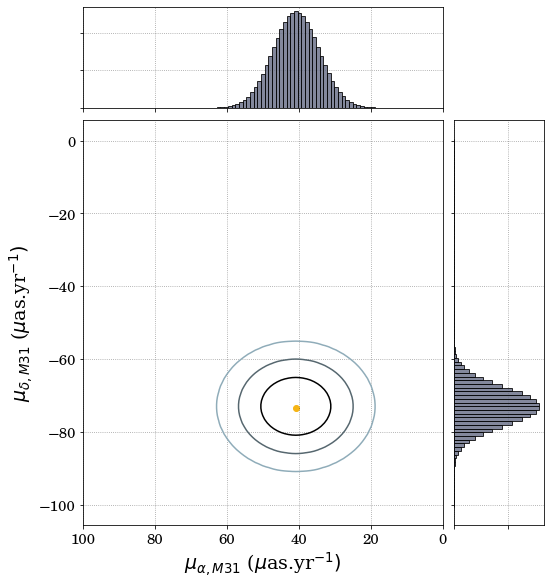

In [105]:
%%time
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [], "CythonLike")
ObjLike.Execute()
ObjLike.Plot()

## With the correlations

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 26.8 s, sys: 15.7 ms, total: 26.8 s
Wall time: 27 s


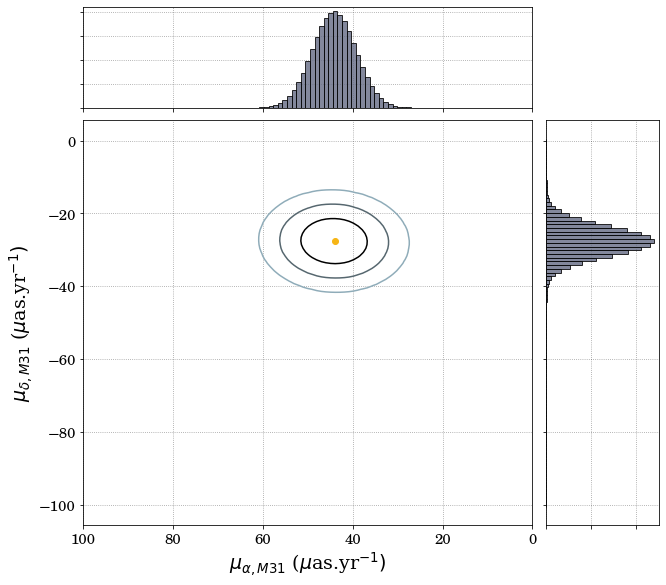

In [257]:
%%time
ObjLike = LikelihooD(99, GaiaDataBlue, ModelDataBlue, [], "CythonLikeCorr")
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

CPU times: user 22.4 s, sys: 13 ms, total: 22.4 s
Wall time: 22.5 s


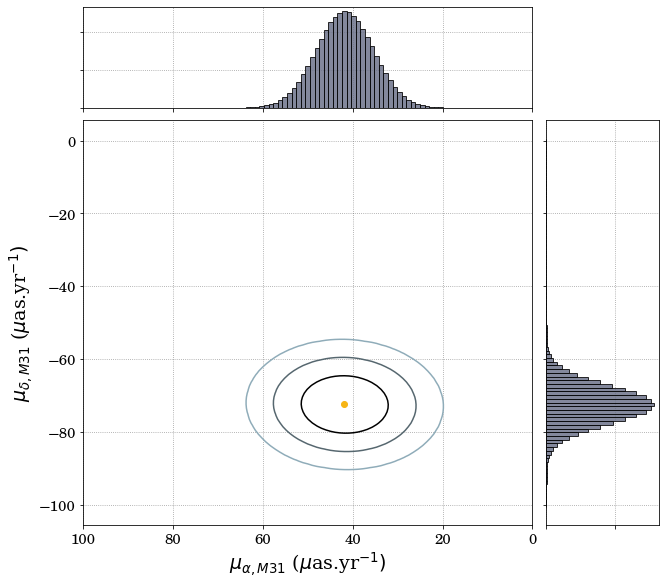

In [258]:
%%time
ObjLike = LikelihooD(99, GaiaDataRed, ModelDataRed, [], "CythonLikeCorr")
ObjLike.Execute()
ObjLike.Plot()

# Contamination 

In [149]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData, MockData, Contamination):
        self.NbModels      = NbModels
        self.Contamination = Contamination
    
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        self.corr             = GaiaData[6]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]
        
        if len(MockData) != 0:
            self.mu_ra_gaia  = MockData[0]
            self.mu_dec_gaia = MockData[1]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.pm_dec_M31), len(self.pm_ra_M31)))
        for i in range(len(self.pm_dec_M31)):
            for j in range(len(self.pm_ra_M31)):
                for k in range(len(self.mu_ra_gaia)):
                    self.LikelihoodList[j,i] += (1 - self.Contamination)*LikelihoodCFunctionCorr(self.pm_ra_M31[i], self.pm_dec_M31[j], 
                                                                    self.mu_ra_model[k], self.mu_dec_model[k],
                                                                    self.mu_ra_sig_gaia[k], self.mu_dec_sig_gaia[k], 
                                                                    self.mu_ra_gaia[k], self.mu_dec_gaia[k], self.corr[k])
                    
                    self.LikelihoodList[j,i] += self.Contamination*LikelihoodCFunction(0, 0, 
                                                                    0.15, -2.69,
                                                                    5.32, 3.55, 
                                                                    0., 0.)

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return self.ra_max, self.index_border_y*self.space, self.dec_max, self.index_border_x*self.space, self.space
                
    def FreeParameters(self):
        #self.pm_ra_M31  = np.linspace(0., 0.1, self.NbModels) 
        #self.pm_dec_M31 = np.linspace(-0.1, 0., self.NbModels)
        self.pm_ra_M31  = np.linspace(-0.05, 0.05, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.05, 0.05, self.NbModels)
        
        self.space = (self.pm_ra_M31[-1] - self.pm_ra_M31[-2])
    
    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.pm_ra_M31)):
            for j in range(len(self.pm_dec_M31)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])
        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.pm_ra_M31[dec_max], self.pm_dec_M31[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
        sum_x = sum(self.x_gaus)
        x_gaus = [x / sum_x for x in self.x_gaus]

        sum_y = sum(self.y_gaus)
        y_gaus = [y / sum_y for y in self.y_gaus]

        self.index_centre_x = x_gaus.index(max(x_gaus))
        self.index_centre_y = y_gaus.index(max(y_gaus))

        sum_x, sum_y = x_gaus[self.index_centre_x], y_gaus[self.index_centre_y]
        
        self.index_border_x = 0
        while sum_x < 0.683:
            self.index_border_x += 1
            sum_x += x_gaus[self.index_centre_x + self.index_border_x]
            sum_x += x_gaus[self.index_centre_x - self.index_border_x]
            
        self.index_border_y = 0
        while sum_y < 0.683:
            self.index_border_y += 1
            sum_y += y_gaus[self.index_centre_y + self.index_border_y]
            sum_y += y_gaus[self.index_centre_y - self.index_border_y]
            
    def Uncertainties(self, x_axis, y_axis):
        def gaussian(x, a, x0, sigma):
            return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
        popt, pcov = curve_fit(gaussian, x_axis, y_axis)
        
        return popt
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x * 1000 for x in self.pm_ra_M31], [x * 1000 for x in self.pm_dec_M31], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#8FACB9', '#56676F', '#000000'])
            ax.scatter(self.ra_max*1000, self.dec_max*1000, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.pm_dec_M31)):
                self.x_bins.append(self.pm_ra_M31[i] - self.space/2)
            for i in range(len(self.pm_ra_M31)):
                self.y_bins.append(self.pm_dec_M31[i] - self.space/2)

            #Plot of the RA histogram
            ax_histx.bar([x * 1000 for x in self.x_bins], self.y_gaus, width=self.space*1000, align='edge', 
                         edgecolor='black', color='#646b84', alpha=0.8, zorder=3)
            ax_histx.set_yticklabels([])
            ax_histx.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            #self.popt_ra = self.Uncertainties(self.x_bins, self.y_gaus) #deduction std
            
            #Plot of the DEC histogram
            colors = self.x_gaus / np.max(self.x_gaus)
            ax_histy.barh([x * 1000 for x in self.y_bins], self.x_gaus, height=self.space*1000, align='edge', 
                          edgecolor='black', color='#646b84', alpha=0.8, zorder=3)
            ax_histy.set_xticklabels([])
            ax_histy.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            #self.popt_dec = self.Uncertainties(self.y_bins, self.x_gaus) #deduction std
        
        fig = plt.figure(figsize=(8, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\alpha, M31} = " + str(round(self.ra_max*1000, 2)) + "\pm" + str(
            round(abs(self.index_border_y*self.space*1000), 1)) + r"\ \mu as/yr"))
        display(Math(r"\mu_{\delta, M31} = " + str(round(self.dec_max*1000, 2)) + "\pm" + str(
            round(abs(self.index_border_x*self.space*1000), 1))  + r"\ \mu as/yr"))

## With the cut on the proper motion

I have not yet really insisted upon the fact that for all the previous determination of the best fit parameters, we have only used the data for the blue and the red sample on which we had made a cut on the proper motion (it is made at the end of the Jupyter named 'CleaningCuts').

Just as quick reminder the values of the estimated contaminations for the sample that have a treatment on the proper motion are of 0.9% for the blue sample and of 2.7% for the red sample.

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

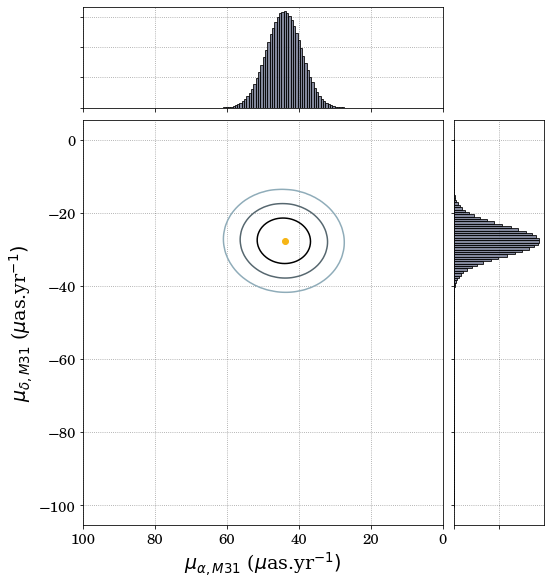

In [96]:
ObjLike = LikelihooD(156, GaiaDataBlue, ModelDataBlue, [], 0.009)
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

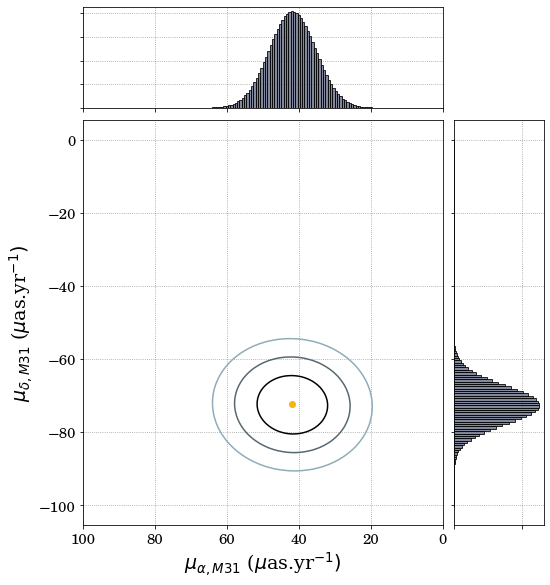

In [97]:
ObjLike = LikelihooD(156, GaiaDataRed, ModelDataRed, [], 0.027)
ObjLike.Execute()
ObjLike.Plot()

## Without the cut on the proper motion

What could be interesting now could be to look at the answer we get in the case for which we don't make the cut on the proper motion. For those "untreated" samples, the contamination levels are way higher, of the order of 1.8% for the blue sample and 33.2% for the red sample.

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

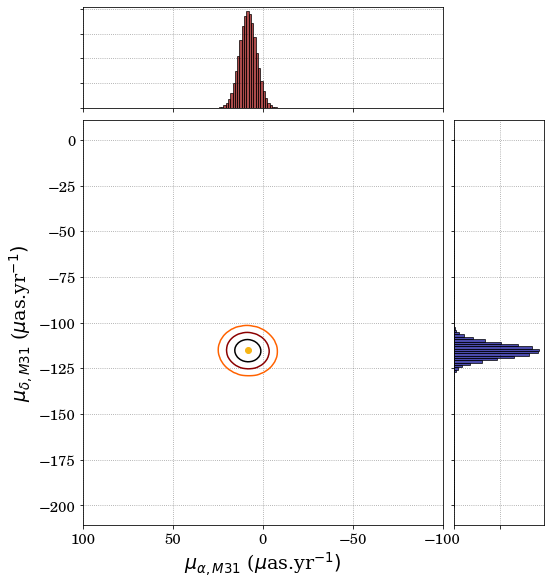

In [87]:
ObjLike = LikelihooD(156, GaiaDataBlue, ModelDataBlue, [], 0.018)
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

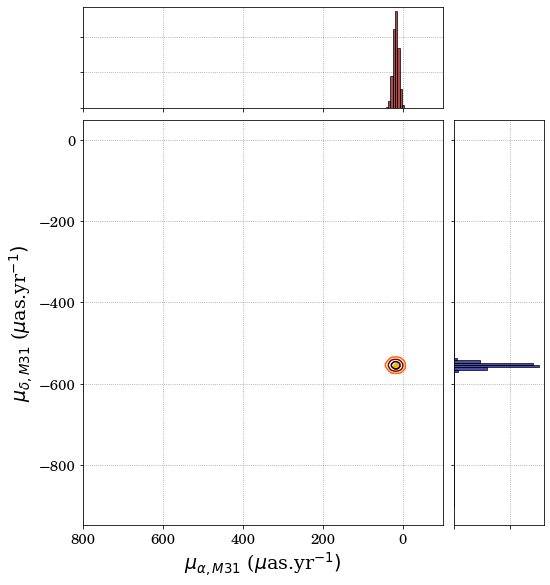

In [85]:
ObjLike = LikelihooD(156, GaiaDataRed, ModelDataRed, [], 0.332)
ObjLike.Execute()
ObjLike.Plot()

# Doing the quadrant thingy

### Define the quadrants

In [33]:
def ElContaminant(RA, DEC, Num): 
    #___ Description_____________________________________________________________________________________
    #Arguments:: This function basically is a simplified function than the one found from 'CleaningCuts' 
    #           It separates the space in 4 quadrant here being N(Num=1), S(Num=2), E(Num=3), W(Num=0). 
    #           RA and DEC position of objects.
    #Returns:: returns either true or false if the object is in one of the four quadrant or not
    #____________________________________________________________________________________________________
    Ra, Dec = RA, DEC
    Result = False
    
    Sign = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
    
    PA     = 37.5*np.pi/180 #Angle choosen because along major axis of the ellipse
    
    AngDia2 = 9 #degrees, inclination angle
    A     = AngDia2
    B     = AngDia2
    
    R_rot = np.array([[np.cos(PA), -np.sin(PA)], [np.sin(PA), np.cos(PA)]])
    
    Ell_rot = np.dot(R_rot, [Ra, Dec])
    if (Ell_rot[0]**2)/(A**2) + (Ell_rot[1]**2)/(B**2) <= 1: #Keeps every stars in the big ellipse
        if Sign[Num][0]*Ell_rot[0]*np.cos(PA) < 0 and Sign[Num][1]*Ell_rot[1]*np.sin(PA) < 0: #Linear selection along lines
            Result = True

    return Result

In [34]:
def Quadrant(evt_data, Number):
    #___ Description_____________________________________________________________________________________
    #Arguments:: Astropy table in which we find RA and DEC coordinates and a number (see ElContaminant)
    #Returns:: list of the coordinates in the choosen quadrant and also the corresponding pm...
    #____________________________________________________________________________________________________
    
    Result = [[], [], [], [], [], [], []]

    for i in range(len(evt_data[0])):
        if ElContaminant(evt_data[0][i], evt_data[1][i], Number) == True:
            Result[0].append(evt_data[0][i])
            Result[1].append(evt_data[1][i])
            Result[2].append(evt_data[2][i])
            Result[3].append(evt_data[3][i])
            Result[4].append(evt_data[4][i])
            Result[5].append(evt_data[5][i])
            Result[6].append(evt_data[6][i])
        
    return Result

In [35]:
Blue1 = Quadrant(GaiaDataBlue, 0) #Western
Blue2 = Quadrant(GaiaDataBlue, 1) #Northern
Blue3 = Quadrant(GaiaDataBlue, 2) #Southern
Blue4 = Quadrant(GaiaDataBlue, 3) #Eastern

In [36]:
Red1 = Quadrant(GaiaDataRed, 0) #Western
Red2 = Quadrant(GaiaDataRed, 1) #Northern
Red3 = Quadrant(GaiaDataRed, 2) #Southern
Red4 = Quadrant(GaiaDataRed, 3) #Eastern

In [37]:
ModelBlue1 = OrganiseModelData(Blue1[0], Blue1[1], xb, yb, vb)
ModelBlue2 = OrganiseModelData(Blue2[0], Blue2[1], xb, yb, vb)
ModelBlue3 = OrganiseModelData(Blue3[0], Blue3[1], xb, yb, vb)
ModelBlue4 = OrganiseModelData(Blue4[0], Blue4[1], xb, yb, vb)

In [38]:
ModelRed1 = OrganiseModelData(Red1[0], Red1[1], xb, yb, vb)
ModelRed2 = OrganiseModelData(Red2[0], Red2[1], xb, yb, vb)
ModelRed3 = OrganiseModelData(Red3[0], Red3[1], xb, yb, vb)
ModelRed4 = OrganiseModelData(Red4[0], Red4[1], xb, yb, vb)

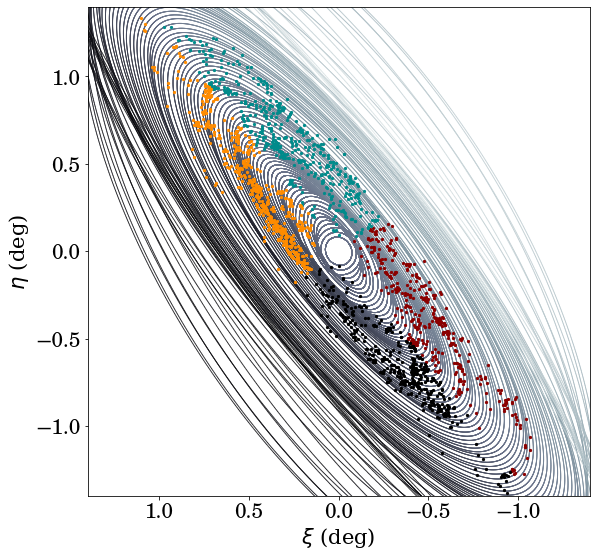

In [39]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap=cmap, s=1, linewidth=0)

for i in range(len(Blue1[0])):
    plt.scatter(Blue1[0][i], Blue1[1][i], s=5, color='darkred')
    
for i in range(len(Blue2[0])):
    plt.scatter(Blue2[0][i], Blue2[1][i], s=5, color='darkcyan')
    
for i in range(len(Blue3[0])):
    plt.scatter(Blue3[0][i], Blue3[1][i], s=5, color='black')

for i in range(len(Blue4[0])):
    plt.scatter(Blue4[0][i], Blue4[1][i], s=5, color='darkorange')
                
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-1.4, 1.4)
plt.ylim(-1.4, 1.4)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('42.png', dpi=150)
plt.show()

In [89]:
def VarianceWeights(Values):
    #Let's first determine the weights 
    WeightA = []
    WeightD = []

    for i in range(4):
        WeightA.append(1/(Values[i][1]*Values[i][1]))
        WeightD.append(1/(Values[i][3]*Values[i][3]))
        
    Result   = np.zeros(4)
    
    SumA = np.sum(WeightA)
    SumD= np.sum(WeightD)
    
    for i in range(4):
        Result[0] += (Values[i][0]*WeightA[i])/SumA
        Result[1] +=  np.sqrt(1/SumA)
        Result[2] += (Values[i][2]*WeightD[i])/SumD
        Result[3] +=  np.sqrt(1/SumD)
        
    return Result

## Blue stars

Take the following interval::

        self.pm_ra_M31  = np.linspace(-0.01, 0.130, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.1, 0.04, self.NbModels)

In [122]:
AnswerBlue = [ [], [], [], [] ]

In [123]:
ObjLike       = LikelihooD(221, Blue1, ModelBlue1, [], "CythonLikeCorr")
AnswerBlue[0] = ObjLike.Execute()
#ObjLike.Plot()

In [124]:
ObjLike       = LikelihooD(221, Blue2, ModelBlue2, [], "CythonLikeCorr")
AnswerBlue[1] = ObjLike.Execute()
#ObjLike.Plot()

In [125]:
ObjLike       = LikelihooD(221, Blue3, ModelBlue3, [], "CythonLikeCorr")
AnswerBlue[2] = ObjLike.Execute()
#ObjLike.Plot()

In [126]:
ObjLike       = LikelihooD(221, Blue4, ModelBlue4, [], "CythonLikeCorr")
AnswerBlue[3] = ObjLike.Execute()
#ObjLike.Plot()

In [92]:
AveragedBlue = VarianceWeights(AnswerBlue)

In [93]:
BlueResults = Table()

BlueResults['Quadrant'] = ["Western", "Northern", "Southern", "Eastern", "Average"]

BlueResults['Alpha'] = [str(round(AnswerBlue[0][0], 1)) + "±" + str(round(AnswerBlue[0][1], 1)
                     ), str(round(AnswerBlue[1][0], 1)) + "±" + str(round(AnswerBlue[1][1], 1)
                     ), str(round(AnswerBlue[2][0], 1)) + "±" + str(round(AnswerBlue[2][1], 1)
                     ), str(round(AnswerBlue[3][0], 1)) + "±" + str(round(AnswerBlue[3][1], 1)
                     ), str(round(AveragedBlue[0], 1)) + r"±" + str(round(AveragedBlue[1], 1))]
                        

BlueResults['Delta'] = [str(round(AnswerBlue[0][2], 1)) + "±" + str(round(AnswerBlue[0][3], 1)
                     ), str(round(AnswerBlue[1][2], 1)) + "±" + str(round(AnswerBlue[1][3], 1)
                     ), str(round(AnswerBlue[2][2], 1)) + "±" + str(round(AnswerBlue[2][3], 1)
                     ), str(round(AnswerBlue[3][2], 1)) + "±" + str(round(AnswerBlue[3][3], 1)
                     ), str(round(AveragedBlue[2], 1)) + r"±" + str(round(AveragedBlue[3], 1))]

BlueResults['Nb. stars'] = [str(len(Blue1[0])), str(len(Blue2[0])), str(len(Blue3[0])
                            ), str(len(Blue4[0])), str(len(GaiaDataBlue[0]))]

display(BlueResults)

Quadrant,Alpha,Delta,Nb. stars
str8,str9,str10,str4
Western,53.6±10.8,-20.5±9.5,389
Northern,53.0±9.5,-23.6±8.3,493
Southern,54.9±11.5,-16.6±9.5,439
Eastern,27.5±8.3,-38.9±6.4,546
Average,44.6±19.6,-28.0±16.2,1867


## Red stars

Take the following interval::

        self.pm_ra_M31  = np.linspace(-0.06, 0.120, self.NbModels) 
        self.pm_dec_M31 = np.linspace(-0.15, 0.03, self.NbModels)

In [95]:
AnswerRed = [ [], [], [], [] ]

In [96]:
ObjLike      = LikelihooD(221, Red1, ModelRed1, [], "CythonLikeCorr")
AnswerRed[0] = ObjLike.Execute()
#ObjLike.Plot()

In [97]:
ObjLike      = LikelihooD(221, Red2, ModelRed2, [], "CythonLikeCorr")
AnswerRed[1] = ObjLike.Execute()
#ObjLike.Plot()

In [98]:
ObjLike      = LikelihooD(221, Red3, ModelRed3, [], "CythonLikeCorr")
AnswerRed[2] = ObjLike.Execute()
#ObjLike.Plot()

In [99]:
ObjLike      = LikelihooD(221, Red4, ModelRed4, [], "CythonLikeCorr")
AnswerRed[3] = ObjLike.Execute()
#ObjLike.Plot()

In [100]:
AveragedRed = VarianceWeights(AnswerRed)

In [101]:
RedResults = Table()

RedResults['Quadrant'] = ["Western", "Northern", "Southern", "Eastern", "Average"]

RedResults['Alpha'] = [str(round(AnswerRed[0][0], 1)) + "±" + str(round(AnswerRed[0][1], 1)
                    ), str(round(AnswerRed[1][0], 1)) + "±" + str(round(AnswerRed[1][1], 1)
                    ), str(round(AnswerRed[2][0], 1)) + "±" + str(round(AnswerRed[2][1], 1)
                    ), str(round(AnswerRed[3][0], 1)) + "±" + str(round(AnswerRed[3][1], 1)
                    ), str(round(AveragedRed[0], 1)) + r"±" + str(round(AveragedRed[1], 1))]
                        

RedResults['Delta'] = [str(round(AnswerRed[0][2], 1)) + "±" + str(round(AnswerRed[0][3], 1)
                    ), str(round(AnswerRed[1][2], 1)) + "±" + str(round(AnswerRed[1][3], 1)
                    ), str(round(AnswerRed[2][2], 1)) + "±" + str(round(AnswerRed[2][3], 1)
                    ), str(round(AnswerRed[3][2], 1)) + "±" + str(round(AnswerRed[3][3], 1)
                    ), str(round(AveragedRed[2], 1)) + r"±" + str(round(AveragedRed[3], 1))]

RedResults['Nb. stars'] = [str(len(Red1[0])), str(len(Red2[0])), str(len(Red3[0])
                            ), str(len(Red4[0])), str(len(GaiaDataRed[0]))]

display(RedResults)

Quadrant,Alpha,Delta,Nb. stars
str8,str9,str10,str4
Western,29.2±14.7,-69.8±12.3,291
Northern,37.4±12.3,-70.6±9.8,422
Southern,45.5±12.3,-80.5±10.6,407
Eastern,50.5±12.3,-69.8±9.8,423
Average,41.6±25.5,-72.6±21.0,1543


### Taking into account the systematics

In [103]:
#List[[value W, uncer. W], [""N, ""N], [""S, ""S], [""E, ""E]]
SystematicsAlpha = [ [-15.5, 5.9], [-3.6, 5.5], [0.9, 8.2] , [7.7, 6.8] ]
SystematicsDelta = [ [-14.1, 5.5], [-8.2, 5.5], [-2.3, 5.0], [-5.0, 5.5] ]

#### Final results and uncertainties 

Blue sample

In [153]:
UpdateB = [ [], [], [], [] ]

for i in range(4):
    #Along alpha, first the value and secondly the uncertainty
    UpdateB[i].append(AnswerBlue[i][0] - SystematicsAlpha[i][0])
    UpdateB[i].append(np.sqrt(AnswerBlue[i][1]**2 + SystematicsAlpha[i][1]**2))
    
    #Along delta, "..."
    UpdateB[i].append(AnswerBlue[i][2] - SystematicsDelta[i][0])
    UpdateB[i].append(np.sqrt(AnswerBlue[i][3]**2 + SystematicsDelta[i][1]**2))

In [154]:
AveragedBlue = VarianceWeights(UpdateB)

In [155]:
FinalResultsB = Table()

FinalResultsB['Quadrant'] = ["Western", "Northern", "Southern", "Eastern", "Average"]

FinalResultsB['Alpha'] = [str(round(UpdateB[0][0], 1)) + "±" + str(round(UpdateB[0][1], 1)
                    ), str(round(UpdateB[1][0], 1)) + "±" + str(round(UpdateB[1][1], 1)
                    ), str(round(UpdateB[2][0], 1)) + "±" + str(round(UpdateB[2][1], 1)
                    ), str(round(UpdateB[3][0], 1)) + "±" + str(round(UpdateB[3][1], 1)
                    ), str(round(AveragedBlue[0], 1)) + r"±" + str(round(AveragedBlue[1], 1))]
                        

FinalResultsB['Delta'] = [str(round(UpdateB[0][2], 1)) + "±" + str(round(UpdateB[0][3], 1)
                    ), str(round(UpdateB[1][2], 1)) + "±" + str(round(UpdateB[1][3], 1)
                    ), str(round(UpdateB[2][2], 1)) + "±" + str(round(UpdateB[2][3], 1)
                    ), str(round(UpdateB[3][2], 1)) + "±" + str(round(UpdateB[3][3], 1)
                    ), str(round(AveragedBlue[2], 1)) + r"±" + str(round(AveragedBlue[3], 1))]

FinalResultsB['Nb. stars'] = [str(len(Blue1[0])), str(len(Blue2[0])), str(len(Blue3[0])
                            ), str(len(Blue4[0])), str(len(GaiaDataBlue[0]))]

display(FinalResultsB)

Quadrant,Alpha,Delta,Nb. stars
str8,str9,str10,str4
Western,69.1±12.3,-6.4±11.0,389
Northern,56.6±11.0,-15.4±9.9,493
Southern,54.0±14.1,-14.3±10.8,439
Eastern,19.8±10.7,-33.9±8.4,546
Average,47.8±23.7,-19.7±19.7,1867


In [3]:
BlueAlphaQ = [ [69.1, 12.3], [56.6, 11.0], [54.0, 14.1], [19.8, 10.7] ]
BlueDeltaQ = [ [-6.4, 11.0], [-15.4, 9.9], [-14.3, 10.8], [-33.9, 8.4] ]

Red sample

In [156]:
UpdateR = [ [], [], [], [] ]

for i in range(4):
    #Along alpha, first the value and secondly the uncertainty
    UpdateR[i].append(AnswerRed[i][0] - SystematicsAlpha[i][0])
    UpdateR[i].append(np.sqrt(AnswerRed[i][1]**2 + SystematicsAlpha[i][1]**2))
    
    #Along delta, "..."
    UpdateR[i].append(AnswerRed[i][2] - SystematicsDelta[i][0])
    UpdateR[i].append(np.sqrt(AnswerRed[i][3]**2 + SystematicsDelta[i][1]**2))

In [157]:
AveragedRed = VarianceWeights(UpdateR)

In [159]:
FinalResultsR = Table()

FinalResultsR['Quadrant'] = ["Western", "Northern", "Southern", "Eastern", "Average"]

FinalResultsR['Alpha'] = [str(round(UpdateR[0][0], 1)) + "±" + str(round(UpdateR[0][1], 1)
                       ), str(round(UpdateR[1][0], 1)) + "±" + str(round(UpdateR[1][1], 1)
                       ), str(round(UpdateR[2][0], 1)) + "±" + str(round(UpdateR[2][1], 1)
                       ), str(round(UpdateR[3][0], 1)) + "±" + str(round(UpdateR[3][1], 1)
                       ), str(round(AveragedRed[0], 1)) + r"±" + str(round(AveragedRed[1], 1))]
                        

FinalResultsR['Delta'] = [str(round(UpdateR[0][2], 1)) + "±" + str(round(UpdateR[0][3], 1)
                       ), str(round(UpdateR[1][2], 1)) + "±" + str(round(UpdateR[1][3], 1)
                       ), str(round(UpdateR[2][2], 1)) + "±" + str(round(UpdateR[2][3], 1)
                       ), str(round(UpdateR[3][2], 1)) + "±" + str(round(UpdateR[3][3], 1)
                       ), str(round(AveragedRed[2], 1)) + r"±" + str(round(AveragedRed[3], 1))]

FinalResultsR['Nb. stars'] = [str(len(Red1[0])), str(len(Red2[0])), str(len(Red3[0])
                            ), str(len(Red4[0])), str(len(GaiaDataRed[0]))]

display(FinalResultsR)

Quadrant,Alpha,Delta,Nb. stars
str8,str9,str10,str4
Western,44.7±15.9,-55.7±13.4,291
Northern,41.0±13.4,-62.4±11.3,422
Southern,44.6±14.8,-78.2±11.8,407
Eastern,42.8±14.0,-64.8±11.3,423
Average,43.1±28.9,-65.8±23.7,1543


In [171]:
RedAlphaQ = [ [44.7, 15.9], [41.0, 13.4], [44.6, 14.8], [42.8, 14.0] ] 
RedDeltaQ = [ [-55.7, 13.4], [-62.4, 11.3], [-78.2, 11.8], [-64.8, 11.3]]

In [213]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, ListElements, CalcMeth):
        self.NbModels = NbModels
        self.CalcMeth = CalcMeth #Calculation method
    
        self.mu_quad     = [sublist[0] for sublist in ListElements]
        self.mu_quad_sig = [sublist[1] for sublist in ListElements]
           
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        method_to_call = getattr(self, self.CalcMeth)
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple                     
        self.LikelihoodList = np.zeros((len(self.mu_sig_param), len(self.mu_param)))
        for i in range(len(self.mu_sig_param)):
            for j in range(len(self.mu_param)):
                for k in range(len(self.mu_quad)):
                    self.LikelihoodList[j,i] += method_to_call(k, i, j)

        self.Renormalisation()  
        
        self.OneDimGaussian()
        
        return
                
    def FreeParameters(self): 
        self.mu_param     = np.linspace(-100, 150, self.NbModels) #For blue stars in quadrants
        self.mu_sig_param = np.linspace(0, 250, self.NbModels)
        
        self.space = (self.mu_param[-1] - self.mu_param[-2])
        
    def PythonLike(self, index_quadrant, index_mu, index_mu_sig):
        SigTot  = np.sqrt(self.mu_sig_param[index_mu_sig]**2 + self.mu_quad_sig[index_quadrant]**2)
        #SigTot  = np.sqrt(self.mu_quad[index_quadrant]**2)
        #print(SigTot)
        #print(index_quadrant)

        PreFactor = 1/(np.sqrt(2*np.pi)*SigTot)    
        Exp       = -0.5*((self.mu_quad[index_quadrant] - self.mu_param[index_mu])/(SigTot))**2
        
        return np.log(PreFactor) + Exp #exp to come back to the L and not ln(L)

    def Renormalisation(self):
        max_likeli = np.max(self.LikelihoodList)
        for i in range(len(self.mu_param)):
            for j in range(len(self.mu_sig_param)):
                self.LikelihoodList[j,i] -= max_likeli
                self.LikelihoodList[j,i] = np.exp(self.LikelihoodList[j,i])

        
        ra_max, dec_max = unravel_index(self.LikelihoodList.argmax(), self.LikelihoodList.shape)
        
        self.ra_max, self.dec_max = self.mu_param[dec_max], self.mu_sig_param[ra_max]
             
    def OneDimGaussian(self):
        self.x_gaus, self.y_gaus = [], []
        for i in range(self.NbModels):
            line = self.LikelihoodList[i, :]
            self.x_gaus.append(np.sum(line))
            
            row = self.LikelihoodList[: ,i]
            self.y_gaus.append((np.sum(row)))
            
        sum_x = sum(self.x_gaus)
        x_gaus = [x / sum_x for x in self.x_gaus]

        sum_y = sum(self.y_gaus)
        y_gaus = [y / sum_y for y in self.y_gaus]

        self.index_centre_x = x_gaus.index(max(x_gaus))
        self.index_centre_y = y_gaus.index(max(y_gaus))

        sum_x, sum_y = x_gaus[self.index_centre_x], y_gaus[self.index_centre_y]

        self.index_border_x = 0
        #while sum_x < 0.683:
            #sum_x += x_gaus[self.index_centre_x + self.index_border_x]
            #sum_x += x_gaus[self.index_centre_x - self.index_border_x]
            
        while sum_x < 0.90:
            self.index_border_x += 1
            if self.index_centre_x - self.index_border_x >= 0:
                sum_x += x_gaus[self.index_centre_x + self.index_border_x]
                sum_x += x_gaus[self.index_centre_x - self.index_border_x]
                
            else:
                sum_x += x_gaus[self.index_centre_x + self.index_border_x]

            
        self.index_border_y = 0
        while sum_y < 0.683:
            self.index_border_y += 1
            sum_y += y_gaus[self.index_centre_y + self.index_border_y]
            sum_y += y_gaus[self.index_centre_y - self.index_border_y]
             
    def Plot(self):
        def scatter_hist(ax, ax_histx, ax_histy):
            ax_histx.tick_params(axis="x", labelleft=False, labelsize=0, labelbottom=False) 
            ax_histy.tick_params(axis="y", labelleft=False, labelsize=0, labelbottom=False)
                       
            ax.contour([x for x in self.mu_param], [x for x in self.mu_sig_param], self.LikelihoodList, 
                    levels=[np.exp(-0.5*11.8), np.exp(-0.5*6.17), np.exp(-0.5*2.3)],  
                    colors=['#8FACB9', '#56676F', '#000000'])
            ax.scatter(self.ra_max, self.dec_max, c="#f6b515")
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_xlabel(r'$\mu_{\alpha, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.set_ylabel(r'$\mu_{\delta, M31}$ ($\mu$as.yr$^{-1})$', fontname = 'Serif', size = 19)
            ax.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            
            ax.set_xlim(ax.get_xlim()[::-1])

            self.x_bins, self.y_bins = [], [] 
            for i in range(len(self.mu_sig_param)):
                self.x_bins.append(self.mu_param[i] - self.space/2)
            for i in range(len(self.mu_param)):
                self.y_bins.append(self.mu_sig_param[i] - self.space/2)

            #Plot of the RA histogram
            ax_histx.bar([x for x in self.x_bins], self.y_gaus, width=self.space, align='edge', 
                         edgecolor='black', color='#646b84', alpha=0.8, zorder=3)
            ax_histx.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            ax_histx.set_yticklabels([])
            
            #Plot of the DEC histogram
            ax_histy.barh([x  for x in self.y_bins], self.x_gaus, height=self.space, align='edge', 
                          edgecolor='black', color='#646b84', alpha=0.8, zorder=3)
            ax_histy.grid(ls = ":", c='black', zorder=self.NbModels, alpha=0.42)
            ax_histy.set_xticklabels([])
        
        fig = plt.figure(figsize=(10, 9))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        scatter_hist(ax, ax_histx, ax_histy)
        
        #plt.savefig('Likelihood.png', dpi=300)
        
        #Because of how I build the array the dec actually corresponds to the ra and vice versa 
        print("Maximum of likelihood:")
        display(Math(r"\mu_{\textrm{all}}= " + str(round(self.ra_max, 1)) + "\pm" +
                     str(round(self.index_border_y*self.space, 1)) + "\pm" +
                     str(round(self.index_border_x*self.space, 1)) + r"\ \mu as/yr"))

Maximum of likelihood:


<IPython.core.display.Math object>

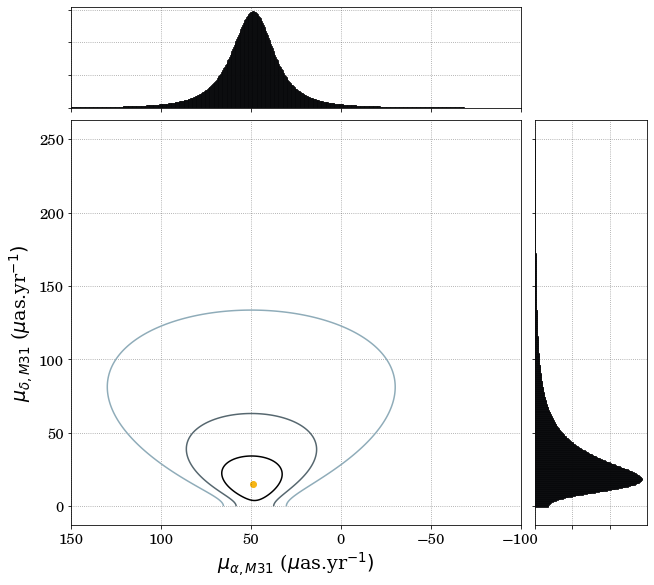

In [214]:
ObjLike = LikelihooD(555, BlueAlphaQ, "PythonLike")
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

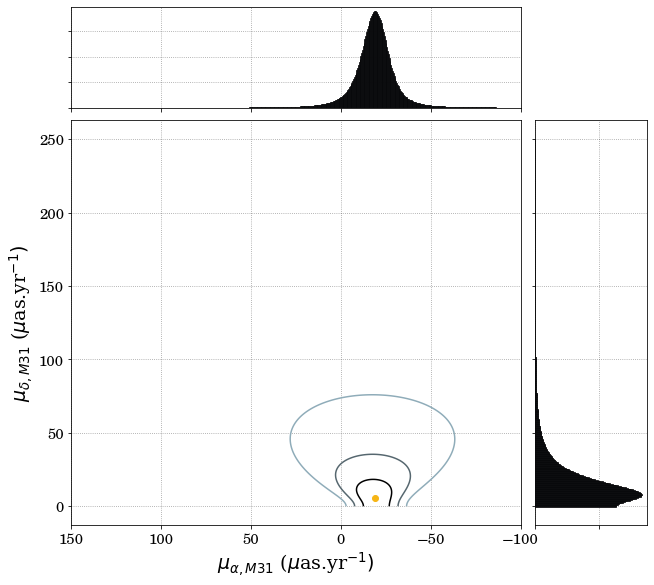

In [215]:
ObjLike = LikelihooD(555, BlueDeltaQ, "PythonLike")
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

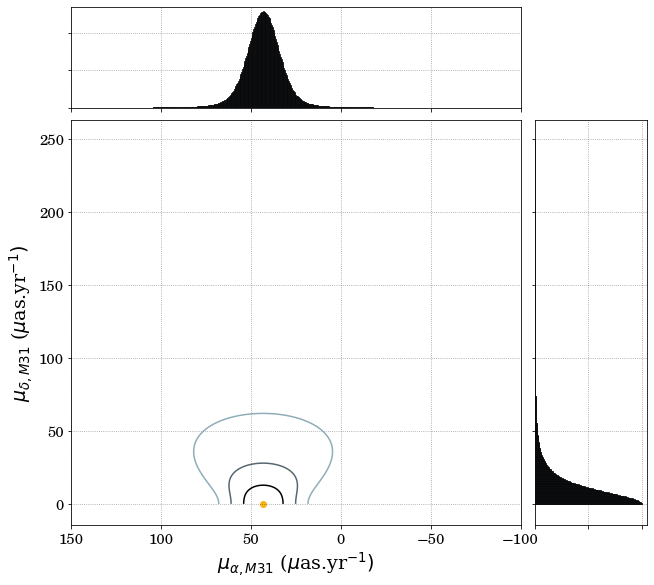

In [216]:
ObjLike = LikelihooD(555, RedAlphaQ, "PythonLike")
ObjLike.Execute()
ObjLike.Plot()

Maximum of likelihood:


<IPython.core.display.Math object>

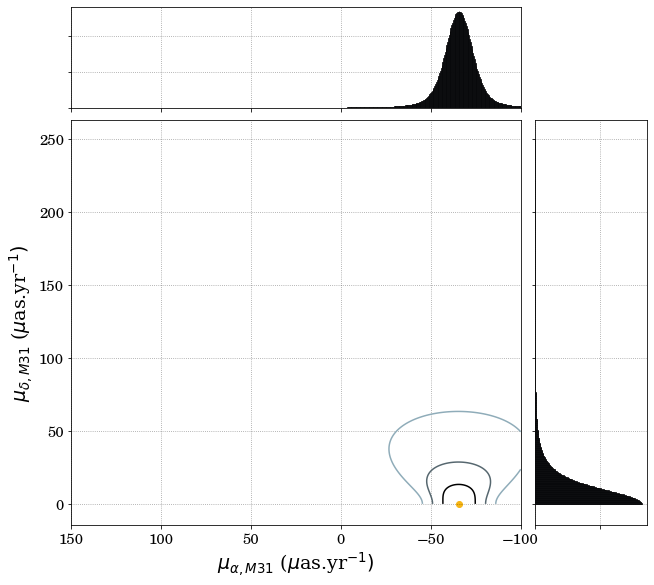

In [217]:
ObjLike = LikelihooD(555, RedDeltaQ, "PythonLike")
ObjLike.Execute()
ObjLike.Plot()

In [1]:
%load_ext Cython

In [2]:
%%cython
from math import pi

cdef extern from "math.h":
    double log(double)

cdef double my_log(double x):
    return log(x)

def LikelihoodCFunction(double pm_ra_M31, double pm_dec_M31, double mu_ra_model, double mu_dec_model,
                        double mu_ra_sig_gaia, double mu_dec_sig_gaia, double mu_ra_gaia, double mu_dec_gaia):
    cdef double GaussianCenter_ra, GaussianCenter_dec, PreFactor, ExpRa, ExpDec
    
    GaussianCenter_ra  = pm_ra_M31 + mu_ra_model
    GaussianCenter_dec = pm_dec_M31 + mu_dec_model

    PreFactor = 1/(2*pi*mu_ra_sig_gaia*mu_dec_sig_gaia)    
    ExpRa  = -0.5*((mu_ra_gaia - GaussianCenter_ra)/(mu_ra_sig_gaia))**2
    ExpDec = -0.5*((mu_dec_gaia - GaussianCenter_dec)/(mu_dec_sig_gaia))**2
    
    return my_log(PreFactor) + ExpRa + ExpDec #exp to come back to the L and not ln(L)

def LikelihoodCFunctionCorr(double pm_ra_M31, double pm_dec_M31, double mu_ra_model, double mu_dec_model,
                        double mu_ra_sig_gaia, double mu_dec_sig_gaia, double mu_ra_gaia, 
                        double mu_dec_gaia, double pm_corr):
    cdef double GaussianCenter_ra, GaussianCenter_dec, PreFactor, ExpRa, ExpDec, ExpCor
    
    GaussianCenter_ra  = pm_ra_M31 + mu_ra_model
    GaussianCenter_dec = pm_dec_M31 + mu_dec_model

    PreFactor = 1/(2*pi*mu_ra_sig_gaia*mu_dec_sig_gaia*(1 - pm_corr**2)**(0.5))    
    ExpRa  = -(1/(2*(1 - pm_corr**2)))*((mu_ra_gaia - GaussianCenter_ra)/(mu_ra_sig_gaia))**2
    ExpDec = -(1/(2*(1 - pm_corr**2)))*((mu_dec_gaia - GaussianCenter_dec)/(mu_dec_sig_gaia))**2
    ExpCor =  (1/(2*(1 - pm_corr**2)))*((2*pm_corr*(mu_ra_gaia - GaussianCenter_ra)*(
              mu_dec_gaia - GaussianCenter_dec))/(mu_ra_sig_gaia*mu_dec_sig_gaia))
    
    return my_log(PreFactor) + ExpRa + ExpDec + ExpCor #exp to come back to the L and not ln(L)